In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import RegressionDNN
from bbb.models.bnn import RegressionBNN
from bbb.data import load_mnist

### Matplotlib Setup

In [35]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Helper Classes

In [36]:
ModelDetails = namedtuple('ModelDetails', 'dir mclass')

## Trained Classification Models

In [62]:
MODEL_DETAILS_DICT = {
    # BNN Baseline
    "bnn_baseline_1": ModelDetails("../saved_models/BBB_regression/baseline/2022-03-13-18.27.02", RegressionBNN),
    "bnn_baseline_2": ModelDetails("../saved_models/BBB_regression/baseline/2022-03-13-18.39.36", RegressionBNN),
    # DNN Baseline
    "dnn_baseline_1": ModelDetails("../saved_models/DNN_regression/baseline/2022-03-14-20.33.27", RegressionDNN),
    "dnn_baseline_2": ModelDetails("../saved_models/DNN_regression/baseline/2022-03-14-20.33.55", RegressionDNN),
    # DNN DO Baseline
    "dnn_do_baseline_1": ModelDetails("../saved_models/DNN_regression/dropout/0.5/2022-03-25-14.00.44", RegressionDNN),
    "dnn_do_baseline_2": ModelDetails("../saved_models/DNN_regression/dropout/0.7/2022-03-25-14.05.23", RegressionDNN),
}

## Set Model

In [63]:
MODEL = "dnn_baseline_1"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
MODEL_DETAILS

ModelDetails(dir='../saved_models/DNN_regression/baseline/2022-03-14-20.33.27', mclass=<class 'bbb.models.dnn.RegressionDNN'>)

## Load Parameters

In [64]:
with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if params_dict['prior_params']:
    params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

params = Parameters(**params_dict)
params

Parameters(name='DNN_regression', input_dim=1, output_dim=1, batch_size=128, epochs=1000, hidden_units=400, hidden_layers=3, lr=0.001, step_size=250, opt_choice='Adam', gamma=0.1, weight_mu_range=None, weight_rho_range=None, prior_params=None, elbo_samples=None, inference_samples=None, regression_likelihood_noise=None, kl_reweighting_type=None, vp_variance_type=None, prior_type=None, local_reparam_trick=False, dropout=False, dropout_p=0.5, early_stopping=False, early_stopping_thresh=0.0001, model_save_basedir='./saved_models', tensorboard_save_dir='./tensorboard')

In [65]:
# models = ['bnn_baseline_1', 'dnn_baseline_1']
models = ['bnn_baseline_2', 'dnn_do_baseline_2', 'dnn_baseline_2']

2022-03-25 14:08:20,408 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 14:08:20,410 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 14:08:20,425 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 14:08:20,427 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 14:08:20,434 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 14:08:20,436 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


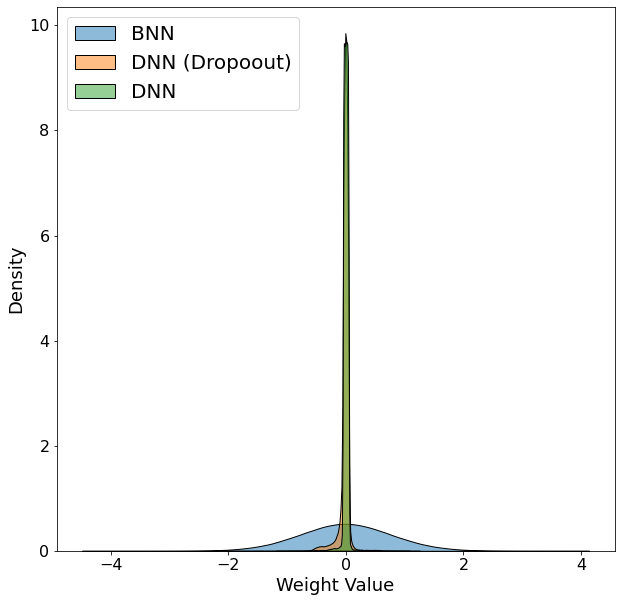

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend(['BNN', 'DNN (Dropoout)', 'DNN'], loc='upper left', prop={'size':20})
plt.savefig(os.path.join("../plots/bbb_regression/baseline/comb_weights_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()